In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('spatial_ref_sys',), ('spatialite_history',), ('sqlite_sequence',), ('geometry_columns',), ('spatial_ref_sys_aux',), ('views_geometry_columns',), ('virts_geometry_columns',), ('geometry_columns_statistics',), ('views_geometry_columns_statistics',), ('virts_geometry_columns_statistics',), ('geometry_columns_field_infos',), ('views_geometry_columns_field_infos',), ('virts_geometry_columns_field_infos',), ('geometry_columns_time',), ('geometry_columns_auth',), ('views_geometry_columns_auth',), ('virts_geometry_columns_auth',), ('sql_statements_log',), ('SpatialIndex',), ('ElementaryGeometries',), ('KNN',), ('Fires',), ('idx_Fires_Shape',), ('idx_Fires_Shape_node',), ('idx_Fires_Shape_rowid',), ('idx_Fires_Shape_parent',), ('NWCG_UnitIDActive_20170109',)]


In [4]:
wildfires = pd.read_sql_query("SELECT * from Fires", con)

Lets take a look at the columns of the original data:

In [5]:
wildfires.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

Now create a separate dataframe with just the columns we want:

In [6]:
fires = wildfires[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]

In [7]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA


In [8]:
fires.shape

(1880465, 12)

Look at original correlation matrix:

In [9]:
corrMatrix = fires.corr()

In [10]:
import seaborn as sn
import matplotlib.pyplot as plt

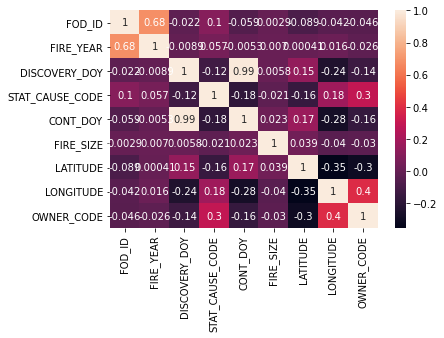

In [11]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [12]:
fires.dtypes

FOD_ID                      int64
NWCG_REPORTING_UNIT_ID     object
FIRE_YEAR                   int64
DISCOVERY_DOY               int64
STAT_CAUSE_CODE           float64
CONT_DOY                  float64
FIRE_SIZE                 float64
FIRE_SIZE_CLASS            object
LATITUDE                  float64
LONGITUDE                 float64
OWNER_CODE                float64
STATE                      object
dtype: object

Start by clustering based on fire size and compare their number of classes to the 'optimal' number found:

In [13]:
from sklearn.cluster import KMeans

In [14]:
# k means based on size of fires

In [15]:
sizes = fires.loc[:,['FOD_ID','FIRE_SIZE']]

In [20]:
sizes.head()

,FOD_ID,FIRE_SIZE
0,1,0.10
1,2,0.25
2,3,0.10
3,4,0.10
4,5,0.10


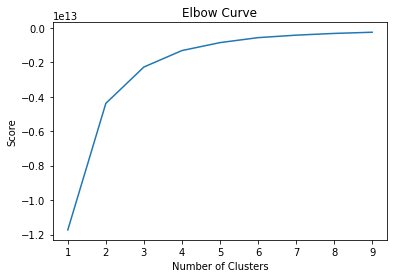

In [19]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = fires[['FIRE_SIZE']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow curve, lets take 3 as our number of optimal clusters

In [21]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(sizes[sizes.columns[1:2]]) 
# Compute k-means clustering.
sizes['cluster_label'] = kmeans.fit_predict(sizes[sizes.columns[1:2]])
centers = kmeans.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans.predict(sizes[sizes.columns[1:2]]) 
# Labels of each point
sizes.head(10)

,FOD_ID,FIRE_SIZE,cluster_label
0,1,0.10,0
1,2,0.25,0
2,3,0.10,0
3,4,0.10,0
4,5,0.10,0
5,6,0.10,0
6,7,0.10,0
7,8,0.80,0
8,9,1.00,0
9,10,0.10,0


In [22]:
centers

array([[4.00992752e+01],
       [2.89765451e+05],
       [7.06198230e+04]])

In [23]:
sizes.FIRE_SIZE.describe()

count    1.880465e+06
mean     7.452016e+01
std      2.497598e+03
min      1.000000e-05
25%      1.000000e-01
50%      1.000000e+00
75%      3.300000e+00
max      6.069450e+05
Name: FIRE_SIZE, dtype: float64

Now lets do a clustering based on location.

In [16]:
locations = fires.loc[:,['FOD_ID','LATITUDE','LONGITUDE']]

In [17]:
locations.head()

,FOD_ID,LATITUDE,LONGITUDE
0,1,40.036944,-121.005833
1,2,38.933056,-120.404444
2,3,38.984167,-120.735556
3,4,38.559167,-119.913333
4,5,38.559167,-119.933056


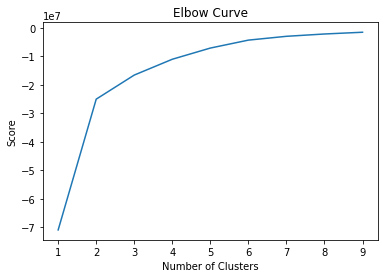

In [26]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = fires[['LATITUDE']]
X_axis = fires[['LONGITUDE']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow curve we can do 4 clusters.

In [19]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(locations[locations.columns[1:3]]) 
# Compute k-means clustering.
locations['cluster_label'] = kmeans.fit_predict(locations[locations.columns[1:3]])
centers = kmeans.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans.predict(locations[locations.columns[1:3]]) 
# Labels of each point
locations.head(10)

,FOD_ID,LATITUDE,LONGITUDE,cluster_label
0,1,40.036944,-121.005833,0
1,2,38.933056,-120.404444,0
2,3,38.984167,-120.735556,0
3,4,38.559167,-119.913333,0
4,5,38.559167,-119.933056,0
5,6,38.635278,-120.103611,0
6,7,38.688333,-120.153333,0
7,8,40.968056,-122.433889,0
8,9,41.233611,-122.283333,0
9,10,38.548333,-120.149167,0


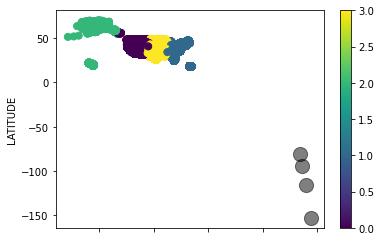

In [20]:
locations.plot.scatter(x = 'LONGITUDE', y = 'LATITUDE', c=labels, s=50, cmap='viridis')
plt.xlabel("LONGITUDE")
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The above map does look like the United States.

In [29]:
locations = locations[['FOD_ID','cluster_label']]

merge clustered locations back in and look at new cluster labels:

In [30]:
new_wildfires = fires.merge(locations, left_on='FOD_ID', right_on='FOD_ID')

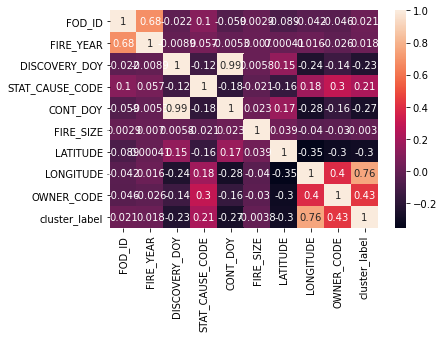

In [31]:
new_corrMatrix = new_wildfires.corr()
sn.heatmap(new_corrMatrix, annot=True)
plt.show()

In [32]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA


Date helper function.

In [33]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [34]:
fires["NEW_DISC_DATE"] = compose_date(fires['FIRE_YEAR'], days=fires['DISCOVERY_DOY'])

<ipython-input-34-bfc1292cf07e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires["NEW_DISC_DATE"] = compose_date(fires['FIRE_YEAR'], days=fires['DISCOVERY_DOY'])


In [35]:
fires.loc[fires['CONT_DOY'] < fires['DISCOVERY_DOY'], 'different_years'] = 1
fires.loc[fires['CONT_DOY'] >= fires['DISCOVERY_DOY'], 'different_years'] = 0

/Users/lukenijhawan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lukenijhawan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
fires["NEW_CONT_DATE"] = compose_date(fires['FIRE_YEAR'] + fires['different_years'], days = fires["CONT_DOY"])

<ipython-input-36-70ca354aead1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires["NEW_CONT_DATE"] = compose_date(fires['FIRE_YEAR'] + fires['different_years'], days = fires["CONT_DOY"])


In [37]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA,2005-02-02,0.0,2005-02-02
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA,2004-05-12,0.0,2004-05-12
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA,2004-05-31,0.0,2004-05-31
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA,2004-06-28,0.0,2004-07-03
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA,2004-06-28,0.0,2004-07-03


In [38]:
fires["CONT_TIME"] = (fires["NEW_CONT_DATE"] - fires["NEW_DISC_DATE"]).dt.days

<ipython-input-38-e2669f65adac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires["CONT_TIME"] = (fires["NEW_CONT_DATE"] - fires["NEW_DISC_DATE"]).dt.days


In [39]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA,2005-02-02,0.0,2005-02-02,0.0
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA,2004-05-12,0.0,2004-05-12,0.0
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA,2004-05-31,0.0,2004-05-31,0.0
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA,2004-06-28,0.0,2004-07-03,5.0
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA,2004-06-28,0.0,2004-07-03,5.0


In [40]:
fires.CONT_TIME.describe()

count    988934.000000
mean          1.142863
std           8.304796
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         365.000000
Name: CONT_TIME, dtype: float64

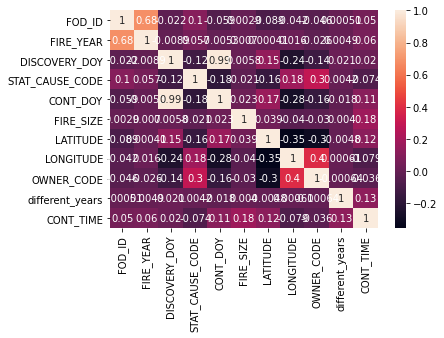

In [41]:
new_corrMatrix = fires.corr()
sn.heatmap(new_corrMatrix, annot=True)
plt.show()

In [42]:
fires.different_years.describe()

count    988934.000000
mean          0.000145
std           0.012024
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: different_years, dtype: float64

Now moving on to try and get other insights from the data:

In [43]:
fires.dtypes

FOD_ID                             int64
NWCG_REPORTING_UNIT_ID            object
FIRE_YEAR                          int64
DISCOVERY_DOY                      int64
STAT_CAUSE_CODE                  float64
CONT_DOY                         float64
FIRE_SIZE                        float64
FIRE_SIZE_CLASS                   object
LATITUDE                         float64
LONGITUDE                        float64
OWNER_CODE                       float64
STATE                             object
NEW_DISC_DATE             datetime64[ns]
different_years                  float64
NEW_CONT_DATE             datetime64[ns]
CONT_TIME                        float64
dtype: object

In [44]:
new_wildfires.dtypes

FOD_ID                      int64
NWCG_REPORTING_UNIT_ID     object
FIRE_YEAR                   int64
DISCOVERY_DOY               int64
STAT_CAUSE_CODE           float64
CONT_DOY                  float64
FIRE_SIZE                 float64
FIRE_SIZE_CLASS            object
LATITUDE                  float64
LONGITUDE                 float64
OWNER_CODE                float64
STATE                      object
cluster_label               int32
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x198ae86a0>]],
      dtype=object)

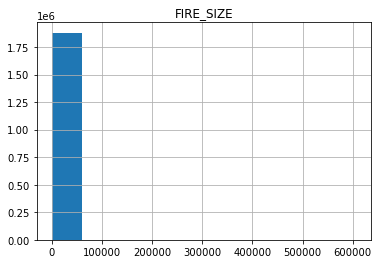

In [45]:
new_wildfires.hist(column="FIRE_SIZE")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19f3de760>]],
      dtype=object)

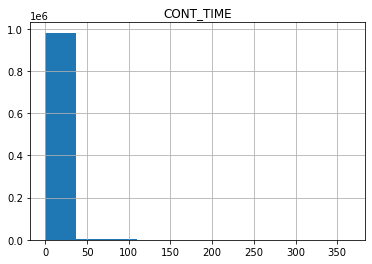

In [46]:
fires.hist(column="CONT_TIME")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19fc88250>]],
      dtype=object)

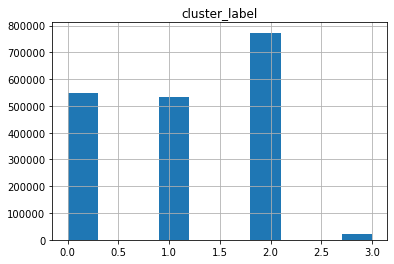

In [47]:
new_wildfires.hist(column="cluster_label")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19ff729d0>]],
      dtype=object)

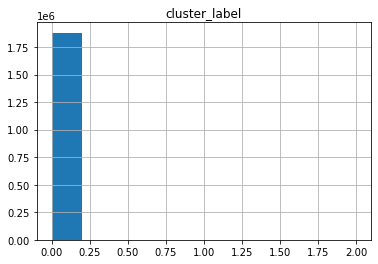

In [48]:
sizes.hist(column="cluster_label")